In [1]:
import sys
sys.path.insert(0, '/cndd/fangming/CEMBA/snmcseq_dev')
sys.path.insert(0, '/cndd/fangming/CEMBA/scripts/ClusterCrossValidation')
import importlib


from __init__ import *
from __init__jupyterlab import *
from scipy import sparse
import collections
import itertools
import re
import fbpca
from sklearn.model_selection import KFold
import pickle

import snmcseq_utils
importlib.reload(snmcseq_utils)
import CEMBA_run_tsne
import CEMBA_clst_utils
import SCF_utils
importlib.reload(SCF_utils)

import cluster_cv_utils
importlib.reload(cluster_cv_utils)
from cluster_cv_utils import *

In [2]:
# def split_genes(gene_chrom_lookup, split_frac=0.8):
#     """
#     Gene_chrom_lookup: pd.Series gene->chrom (int, 1-20)
#     """
#     gene_chrom_nums = gene_chrom_lookup.value_counts()
#     chrom_order = np.random.permutation(gene_chrom_nums.index.values)
#     gene_chrom_nums_cumsum = np.cumsum(gene_chrom_nums.loc[chrom_order].values)
#     cond = gene_chrom_nums_cumsum < gene_chrom_nums_cumsum[-1]*split_frac
#     chrom_order_0 = chrom_order[cond]
#     chrom_order_1 = chrom_order[~cond]
#     chrom_set_lookup = {chrom: bl for chrom, bl in zip(chrom_order, cond)}
#     gene_set_lookup = gene_chrom_lookup.apply(lambda x: chrom_set_lookup[x])
#     logging.info('Cluster chrom: {}, feature chrom {}'.format(chrom_order_0, chrom_order_1))
    
#     return gene_set_lookup


# def split_features_routine(mods_selected, settings, gxc_hvftrs_sub, gene_set_lookup):
#     gxc_hvftrs_sub_g0 = collections.OrderedDict()
#     gxc_hvftrs_sub_g1 = collections.OrderedDict()
#     for mod in mods_selected: 
#         # split gxc_hvftrs
#         if settings[mod].mod_category == 'mc':
#             _genes = gxc_hvftrs_sub[mod].index.values
#             _lookup = gene_set_lookup.reindex(_genes).fillna(-1).values
#             _genes_set0 = _genes[_lookup == 0]
#             _genes_set1 = _genes[_lookup == 1]
#             print(len(_genes_set0), len(_genes_set1))
#             gxc_hvftrs_sub_g0[mod] = gxc_hvftrs_sub[mod].loc[_genes_set0]
#             gxc_hvftrs_sub_g1[mod] = gxc_hvftrs_sub[mod].loc[_genes_set1]

#             logging.info('Finish split {}: {} -> {} {}'.format(mod, gxc_hvftrs_sub[mod].shape, 
#                                                                gxc_hvftrs_sub_g0[mod].shape, gxc_hvftrs_sub_g1[mod].shape))
#             continue

#         _genes = gxc_hvftrs_sub[mod].gene
#         _lookup = gene_set_lookup.reindex(_genes).fillna(-1).values
#         _genes_set0 = _genes[_lookup == 0]
#         _genes_set0_index = snmcseq_utils.get_index_from_array(_genes, _genes_set0)
#         _genes_set1 = _genes[_lookup == 1]
#         _genes_set1_index = snmcseq_utils.get_index_from_array(_genes, _genes_set1)
#         print(len(_genes_set0), len(_genes_set1))
#         gxc_hvftrs_sub_g0[mod] = GC_matrix(
#                                     _genes_set0,
#                                     gxc_hvftrs_sub[mod].cell,
#                                     gxc_hvftrs_sub[mod].data.tocsr()[_genes_set0_index,:],
#                                     )
#         gxc_hvftrs_sub_g1[mod] = GC_matrix(
#                                     _genes_set1,
#                                     gxc_hvftrs_sub[mod].cell,
#                                     gxc_hvftrs_sub[mod].data.tocsr()[_genes_set1_index,:],
#                                     )

#         logging.info('Finish split {}: {} -> {} {}'.format(mod, gxc_hvftrs_sub[mod].data.shape, 
#                                                            gxc_hvftrs_sub_g0[mod].data.shape, gxc_hvftrs_sub_g1[mod].data.shape))
        
#     return gxc_hvftrs_sub_g0, gxc_hvftrs_sub_g1

In [3]:
# def subsampling(mods_selected, metas, gxc_hvftrs, p):
#     """
#     p - fraction of cells from each dataset to be included
#     """
#     metas_sub = collections.OrderedDict()
#     gxc_hvftrs_sub = collections.OrderedDict()
#     for mod in mods_selected: 
#         # subsample meta
#         cells_included = metas[mod].index.values[np.random.rand(len(metas[mod]))<p]
#         metas_sub[mod] = metas[mod].loc[cells_included]

#         # subsample gxc_hvftrs
#         if settings[mod].mod_category == 'mc':
#             gxc_hvftrs_sub[mod] = gxc_hvftrs[mod][cells_included]
#             print(mod, metas_sub[mod].shape, gxc_hvftrs_sub[mod].shape, time.time()-ti)
#             continue

#         cells_included_idx = snmcseq_utils.get_index_from_array(gxc_hvftrs[mod].cell, cells_included)
#         gxc_hvftrs_sub[mod] = GC_matrix(
#                                         gxc_hvftrs[mod].gene,
#                                         cells_included,
#                                         gxc_hvftrs[mod].data.tocsc()[:, cells_included_idx],
#                                         )
#         print(mod, metas_sub[mod].shape, gxc_hvftrs_sub[mod].data.shape, time.time()-ti)
#     return metas_sub, gxc_hvftrs_sub

In [4]:
# def centroid_prediction_model_cv(metadata, features_y, n_repeats, nfolds):
#     """Prediction of y with centroids (x is the cluster label), return training and test MSEs (cross-validated) for n_repeats 
#     - metadata: DataFrame, indexed by cell_name, "cluster_cv" as a column
#     - features_y: Numpy array, Feature matrix cell by feature
#     """
#     # Assuming metadata and features_y has the same order of cells
    
#     kl = KFold(n_splits=nfolds)
#     ncells = len(metadata)
#     res = []
#     cells_clst = metadata['cluster_cv']
    
#     for i_repeat in range(n_repeats):
#         print('.', end='')
#         # shuffle data
#         cells_shuffled_idx = np.random.permutation(np.arange(ncells))
#         metadata = metadata.iloc[cells_shuffled_idx, :] 
#         metadata['cell_idx'] = np.arange(ncells)
#         features_y = features_y[cells_shuffled_idx, :]

#         # split training and test 
#         for i_fold, (train_idx, test_idx) in enumerate(kl.split(np.arange(ncells))):
#             ti = time.time()
#             # compute cluster centroids for training cells 
#             metadata_train = metadata.iloc[train_idx]
#             clsts_in_train = np.unique(metadata_train['cluster_cv'].values)
#             clsts_not_in_train = np.unique(metadata['cluster_cv'].values).tolist()
#             y_centroids = np.zeros((len(clsts_in_train), features_y.shape[1]))
#             cluster_to_idx_lookup = {}
#             for count_idx, (clst, df_sub) in enumerate(metadata_train.groupby('cluster_cv')):
#                 cells_sub_idx = df_sub['cell_idx'].values
#                 y_centroids[count_idx, :] = features_y[cells_sub_idx, :].mean(axis=0)
#                 cluster_to_idx_lookup[clst] = count_idx
#                 clsts_not_in_train.remove(clst)
#             for clst in clsts_not_in_train:
#                 cluster_to_idx_lookup[clst] = -1

#             # compute MSE for test cells
#             cells_j = metadata.index.values[test_idx]
#             clsts_i = cells_clst[cells_j]
#             clsts_i_idx = np.array([cluster_to_idx_lookup[clst] for clst in clsts_i])
#             cond = (clsts_i_idx != -1)  # test if clsts_i in clsts_in_train
#             test_idx, cells_j, clsts_i, clsts_i_idx = test_idx[cond], cells_j[cond], clsts_i[cond], clsts_i_idx[cond]
#             diff = features_y[test_idx, :] - y_centroids[clsts_i_idx, :]
#             mse = (diff**2).sum(axis=1).mean()

#             # compute MSE for training cells 
#             cells_j = metadata_train.index.values
#             clsts_i = cells_clst[cells_j]
#             clsts_i_idx = np.array([cluster_to_idx_lookup[clst] for clst in clsts_i])
#             diff = features_y[train_idx, :] - y_centroids[clsts_i_idx, :]
#             mse_t = (diff*diff).sum(axis=1).mean()
            
#             # collect 1 data point
#             res.append({'mse': mse, 
#                         'mse_t': mse_t, 
#                         'i_fold': i_fold, 
#                         'i_repeat': i_repeat,
#                        })
#         # end of n-fold training test for 
#     # end of n-repeats for
#     res = pd.DataFrame(res)
#     return res 

In [5]:
# read write
def nfoldcv(gxc_hvftrs_sub, resolutions, k, 
            metas_sub, mods_selected, features_selected, settings,   
            ps, drop_npcs,
            cross_mod_distance_measure, knn, relaxation, n_cca,
            npc,
            output_pcX_all, output_cells_all, output_clst_and_umap,
            reduce_dim=0,
            nfolds=5, n_repeats=5, n_splits=5, split_frac=0.8):
    """
    """
    
    res = []
    res_nclsts = []
    # n_splits (split and cluster)
    for n_split in np.arange(n_splits):
        # split features metas_sub, gxc_hvftrs_sub_g0, gxc_hvftrs_sub_g1
        gene_set_lookup = split_genes(gene_chrom_lookup, split_frac=split_frac)
        gxc_hvftrs_sub_g0, gxc_hvftrs_sub_g1 = split_features_routine(mods_selected, settings, gxc_hvftrs_sub, gene_set_lookup)
            
        # test different resolution
        for resolution in resolutions:
            print(resolution, end='')
        
            # cluster on g0 with different resolutions
            mod = mods_selected[0]
            cell_list = gxc_hvftrs_sub_g0[mod].cell
            U, s, Vt = fbpca.pca(gxc_hvftrs_sub_g0[mod].data.todense().T, k=50)
            pcX = U.dot(np.diag(s))
            df_clst = CEMBA_clst_utils.clustering_routine(pcX, cell_list, k, 
                                                        seed=1, verbose=False,
                                                        resolution=resolution, metric='euclidean', option='plain', n_trees=10, search_k=-1, num_starts=None)
            nclsts = len(df_clst['cluster'].unique())
            res_nclsts.append({
                        'resolution': resolution,
                        'i_split': n_split,
                        'nclsts': nclsts,
                        }) # record number of clusters

            # do it in every modality
            for mod in mods_selected:
                print(mod)
                # set up
                metadata = metas_sub[mod].copy()
                metadata['cluster_cv'] = df_clst.loc[metadata.index, 'cluster'] 
                gxc_hvftr = gxc_hvftrs_sub_g1[mod]

                if settings[mod].mod_category == 'mc':
                    assert np.all(metadata.index.values == gxc_hvftr.columns.values)
                    features_y = gxc_hvftr.T.values
                else:
                    assert np.all(metadata.index.values == gxc_hvftr.cell)
                    features_y = pd.DataFrame(gxc_hvftr.data.T.todense(), 
                                              index=gxc_hvftr.cell, 
                                              columns=gxc_hvftr.gene).values
                if reduce_dim:
                    U, s, Vt = fbpca.pca(features_y, k=reduce_dim)
                    features_y = U.dot(np.diag(s))

                # one set CV
                res_cv = centroid_prediction_model_cv(metadata, features_y, n_repeats, nfolds)
                res_cv['mod'] = mod
                res_cv['i_split'] = n_split 
                res_cv['resolution'] =  resolution
                res.append(res_cv)
            # end of n-modality for 
        # end of n-split for 
    # end of resolution for
    res = pd.concat(res, axis=0)
    res_nclsts = pd.DataFrame(res_nclsts)
    return res_nclsts, res 

# Configs  

In [6]:
name = 'mop_smarter_cells_cv_test'
outdir = '/cndd/fangming/CEMBA/data/MOp_all/results'
output_results = outdir + '/cross_validation_results_{}.pkl'.format(name)
output_pcX_all = outdir + '/pcX_all_{}.npy'.format(name)
output_cells_all = outdir + '/cells_all_{}.npy'.format(name)
output_clst_and_umap = outdir + '/intg_summary_{}.tsv'.format(name)

output_figures = outdir + '/figures/{}_{{}}.{{}}'.format(name)
# SAVE_KNN_MAT = True
# output_knn_mat = outdir + '/knn_{}_{{}}_from_{{}}.npz'.format(name)

In [7]:
DATA_DIR = '/cndd/fangming/CEMBA/data/MOp_all/organized_neurons_v6'

# fixed dataset configs
sys.path.insert(0, DATA_DIR)
import __init__datasets
importlib.reload(__init__datasets)
from __init__datasets import *

meta_f = os.path.join(DATA_DIR, '{0}_metadata.tsv')
hvftrs_f = os.path.join(DATA_DIR, '{0}_hvfeatures.{1}')
hvftrs_gene = os.path.join(DATA_DIR, '{0}_hvfeatures.gene')
hvftrs_cell = os.path.join(DATA_DIR, '{0}_hvfeatures.cell')

In [8]:
mods_selected = [
#     'snmcseq_gene',
#     'snatac_gene',
    'smarter_cells',
#     'smarter_nuclei',
#     '10x_cells', 
#     '10x_nuclei', 
#     '10x_cells_v3',
#     '10x_nuclei_v3',
#     '10x_nuclei_v3_Macosko',
    ]

features_selected = mods_selected
# check features
for features_modality in features_selected:
    assert (features_modality in mods_selected)

# within modality
ps = {'mc': 0.9,
      'atac': 0.1,
      'rna': 0.7,
     }
drop_npcs = {'mc': 0,
      'atac': 0,
      'rna': 0,
     }

# across modality
cross_mod_distance_measure = 'correlation' # cca
knn = 20 
relaxation = 3
n_cca = 30

# PCA
npc = 50

# clustering
k = 30
resolutions = [0.8, 1, 2, 4]
# umap
umap_neighbors = 60
min_dist=min_dist = 0.5

## Read in data 

In [9]:
log = snmcseq_utils.create_logger()
logging.info('*')

07/16/2019 04:49:27 PM *


In [10]:
# gene chrome lookup
chroms = np.arange(1, 20, 1).tolist() + ['X']
chroms = ['chr'+str(chrom) for chrom in chroms]

f = PATH_GENEBODY_ANNOTATION
df_genes = pd.read_csv(f, sep="\t")
gene_chrom_lookup = (df_genes[df_genes['chr'].isin(chroms)]
                            .groupby('gene_name').first()['chr']
                            .replace('chrX', 'chr20')
                            .apply(lambda x: int(x[3:]))
                   ) # 1:20
print(gene_chrom_lookup.value_counts())

7     4709
2     3791
1     3433
5     3246
6     3127
11    3002
3     2877
4     2867
9     2851
10    2621
20    2613
8     2533
14    2528
13    2497
12    2455
17    1729
15    1599
16    1195
19    1096
18     902
Name: chr, dtype: int64


In [11]:
metas = collections.OrderedDict()
for mod in mods_selected:
    metas[mod] = pd.read_csv(meta_f.format(mod), sep="\t").reset_index().set_index(settings[mod].cell_col)
    print(mod, metas[mod].shape)

smarter_cells (6244, 11)


In [12]:
gxc_hvftrs = collections.OrderedDict()
for mod in mods_selected:
    print(mod)
    ti = time.time()
    
    if settings[mod].mod_category == 'mc':
        f_mat = hvftrs_f.format(mod, 'tsv')
        gxc_hvftrs[mod] = pd.read_csv(f_mat, sep='\t', header=0, index_col=0) 
        gxc_hvftrs[mod].index = SCF_utils.standardize_gene_name(gxc_hvftrs[mod].index)  # standardize gene name 
        print(gxc_hvftrs[mod].shape, time.time()-ti)
        assert np.all(gxc_hvftrs[mod].columns.values == metas[mod].index.values) # make sure cell name is in the sanme order as metas (important if save knn mat)
        continue
        
        
    f_mat = hvftrs_f.format(mod, 'npz')
    f_gene = hvftrs_gene.format(mod)
    f_cell = hvftrs_cell.format(mod)
    _gxc_tmp = snmcseq_utils.load_gc_matrix(f_gene, f_cell, f_mat)
    _gene = _gxc_tmp.gene
    _cell = _gxc_tmp.cell
    _mat = _gxc_tmp.data

    _gene = SCF_utils.standardize_gene_name(_gene)  # standardize gene name  
    
#     ## remove duplicated genes (for now)
#     u, c = np.unique(_gene, return_counts=True)
#     dup = u[c > 1]
#     uniq_bool = np.array([False if gene in dup else True for gene in _gene])
#     _gene_selected = _gene[uniq_bool]
#     _gene_selected_idx = np.arange(len(_gene))[uniq_bool]
#     _gene = _gene_selected
#     _mat = _mat.tocsr()[_gene_selected_idx, :]
#     ## remove duplicated genes complete
    
    gxc_hvftrs[mod] = GC_matrix(_gene, _cell, _mat)
    assert np.all(gxc_hvftrs[mod].cell == metas[mod].index.values) # make sure cell name is in the sanme order as metas (important if save knn mat)
    print(gxc_hvftrs[mod].data.shape, time.time()-ti)
    

smarter_cells
(4176, 6244) 1.205840826034546


In [13]:
# subsample cells
p = 1

if p < 1:
    metas_sub, gxc_hvftrs_sub = subsampling(mods_selected, metas, gxc_hvftrs, p)
else:
    metas_sub = metas
    gxc_hvftrs_sub = gxc_hvftrs

In [22]:
# resolutions = [0.5, 1, 2, 3, 4, 6, 8, 12, 16, 20, 30, 40, 60, 80, 100]
resolutions = [0.5, 1, 2, 3, 4, 6, 8, 12]
(
 res_nclsts, res, 
) = nfoldcv(
            gxc_hvftrs_sub, resolutions, k, 
            metas_sub, mods_selected, features_selected, settings,   
            ps, drop_npcs,
            cross_mod_distance_measure, knn, relaxation, n_cca,
            npc,
            output_pcX_all, output_cells_all, output_clst_and_umap,
            reduce_dim=0,
            nfolds=5, n_repeats=5, n_splits=5, split_frac=0.5)

07/16/2019 04:56:52 PM Cluster chrom: [ 8 14 13  5 10 17  6 19  4 12], feature chrom [11  7 15  1  9  2  3 18 16 20]
07/16/2019 04:56:52 PM Finish split smarter_cells: (4176, 6244) -> (1653, 6244) (2029, 6244)


1653 2029
0.5smarter_cells
.....1smarter_cells
.....2smarter_cells
.....3smarter_cells
.....4smarter_cells
.....6smarter_cells
.....8smarter_cells
.....12smarter_cells
.....

07/16/2019 04:57:31 PM Cluster chrom: [18  5  6  4 19 13 20 16  3 11 17], feature chrom [ 7  2  8  9 14 15  1 12 10]
07/16/2019 04:57:31 PM Finish split smarter_cells: (4176, 6244) -> (1865, 6244) (1817, 6244)


1865 1817
0.5smarter_cells
.....1smarter_cells
.....2smarter_cells
.....3smarter_cells
.....4smarter_cells
.....6smarter_cells
.....8smarter_cells
.....12smarter_cells
.....

07/16/2019 04:58:06 PM Cluster chrom: [ 7 15 19 17 12 14  5 11 20 13], feature chrom [ 6 18  8  9  4  2  3 16  1 10]
07/16/2019 04:58:06 PM Finish split smarter_cells: (4176, 6244) -> (1760, 6244) (1922, 6244)


1760 1922
0.5smarter_cells
.....1smarter_cells
.....2smarter_cells
.....3smarter_cells
.....4smarter_cells
.....6smarter_cells
.....8smarter_cells
.....12smarter_cells
.....

07/16/2019 04:58:44 PM Cluster chrom: [ 5  6 19 18  3  7 15 13 12 10], feature chrom [ 1  9  4 14 16  2  8 11 17 20]
07/16/2019 04:58:44 PM Finish split smarter_cells: (4176, 6244) -> (1666, 6244) (2016, 6244)


1666 2016
0.5smarter_cells
.....1smarter_cells
.....2smarter_cells
.....3smarter_cells
.....4smarter_cells
.....6smarter_cells
.....8smarter_cells
.....12smarter_cells
.....

07/16/2019 04:59:20 PM Cluster chrom: [ 9 16 17 15  5  4  8  1 20 11], feature chrom [13 14  2  6 12 18 10  7 19  3]
07/16/2019 04:59:20 PM Finish split smarter_cells: (4176, 6244) -> (1910, 6244) (1772, 6244)


1910 1772
0.5smarter_cells
.....1smarter_cells
.....2smarter_cells
.....3smarter_cells
.....4smarter_cells
.....6smarter_cells
.....8smarter_cells
.....12smarter_cells
.....

In [23]:
# Saving the objects:
with open(output_results, 'wb') as f: 
    pickle.dump((
                 res_nclsts, res,
                ), f)

In [24]:
# Getting back the objects:
with open(output_results, 'rb') as f: 
    (
     res_nclsts, res,
    ) = pickle.load(f)

In [25]:
res_nclsts.head()

,i_split,nclsts,resolution
0,0,9,0.5
1,0,11,1.0
2,0,16,2.0
3,0,24,3.0
4,0,26,4.0


In [26]:
res.head()

,i_fold,i_repeat,mse,mse_t,mod,i_split,resolution
0,0,0,259.480608,254.236200,smarter_cells,0,0.5
1,1,0,252.182061,256.058783,smarter_cells,0,0.5
2,2,0,254.874551,255.385342,smarter_cells,0,0.5
3,3,0,256.552479,254.966010,smarter_cells,0,0.5
4,4,0,257.023430,254.850196,smarter_cells,0,0.5


In [27]:
res_nclsts_summary = res_nclsts.groupby('resolution').agg({'nclsts': ['mean', 'std']})
res_nclsts_summary.head()

nclsts          
             mean       std
resolution                 
0.5           8.6  1.140175
1.0          11.4  0.547723
2.0          16.2  0.836660
3.0          23.0  2.449490
4.0          26.6  0.547723

In [28]:
res_summary = res.groupby(['resolution', 'mod']).agg({'mse': ['mean', 'std'],
                                                      'mse_t': ['mean', 'std'],
                                                    })

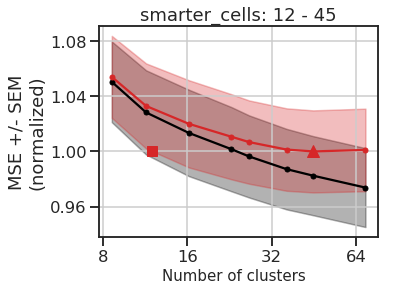

In [29]:
output = output_figures.format('cluster_cv_nosharey', 'pdf')
scale = 1
fig, ax = plt.subplots(1, 1, figsize=(5*scale,4*scale))

n_folds = 5

x = res_nclsts_summary['nclsts']['mean'].values
ys = res_summary.xs(mod, level='mod')
base_level = np.min(ys['mse']['mean'].values)
y, y_err = ys['mse']['mean'].values/base_level, (ys['mse']['std'].values/np.sqrt(n_folds))/base_level, 
yt, yt_err = ys['mse_t']['mean'].values/base_level, (ys['mse_t']['std'].values/np.sqrt(n_folds))/base_level, 

ylabel = 'MSE +/- SEM\n(normalized)'
xlabel = ''
plot_bi_cv_subfig(ax, x, 
                  y, y_err,
                  yt, yt_err,
                  settings[mod].color, mod, 
                  xlabel=xlabel,
                  ylabel=ylabel
                 )
ax.yaxis.set_major_locator(mtick.MaxNLocator(4))

fig.subplots_adjust(wspace=0.1, bottom=0.15)
fig.text(0.5, 0, 'Number of clusters', ha='center', fontsize=15)
fig.savefig(output, bbox_inches='tight')
plt.show()